# Import Libraries and define directories

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from scipy.stats import spearmanr
from tqdm.autonotebook import tqdm
from src.data_preparation import run_gypsumdl
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from src.docking import *
from src.utilities import get_selected_workflow
from src.rescoring import rescoring_function
from src.preprocessing import merge_activity_values, hdbscan_scaffold_split, cv_split, norm_scores
from src.pose_score_optimization import scores_preprocessing, score_pose_optimization, prepare_parameters, prediction, mapping_normalized_weights
from src.interaction_analysis import (
    split_sdf_path, 
    actives_extraction, 
    plipify_fp_interaction, 
    indiviudal_interaction_fp_generator, 
    read_interactions_json, 
    interactions_aggregation
)

from src.ranking import enrichment_factor_calc
import matplotlib.pyplot as plt

from pathlib import Path

ModuleNotFoundError: No module named 'core'

In [4]:
protein_name  = '5UG9_noligand_protoss.pdb'
ligand_library = 'test_three_cpds.sdf'
reference_ligand = 'ref_ligand.pdb'

In [5]:
HERE = Path(_dh[-1])
DATA = (HERE / "test_data")
software = (HERE / "software")
protein_file = (DATA  / protein_name)
ligand_library = (DATA / ligand_library)
ref_file = (DATA /  reference_ligand)


OUTPUT = DATA / "results"
OUTPUT.mkdir(exist_ok=True)

# MolDockLab Workflow

## Prepare ligands library

In [6]:
ligand_library = DATA / 'test_three_cpds.sdf'
output_prepared_mols = DATA / f"{ligand_library.stem}_prepared.sdf"
run_gypsumdl(
    ligand_library=ligand_library, 
    prepared_library_path=output_prepared_mols, 
    id_column="chembl_id"
    )

Molecules are already prepared by Gypsum-DL


In [8]:
# Package for MolDockLab is DockM8 + next libraries

# hdscan
# pip install "fair-esm[esmfold]"
# e3nn


# !cd software/
# !git clone git@github.com:mbackenkoehler/DiffDock.git
# ! git clone git@github.com:sc8668/RTMScore.git
# !cd ../

# pydantic
# pip install dgl==1.1.3

Cloning into 'DiffDock'...
remote: Enumerating objects: 484, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 484 (delta 192), reused 235 (delta 138), pack-reused 148
Receiving objects: 100% (484/484), 233.07 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (221/221), done.


## Consensus Docking

In [10]:
docking_programs = [
                'GNINA', 
                'SMINA',
                'diffdock', 
                'PLANTS', 
                'flexx',
                ]

n_poses = 10
exhaustiveness = 8

In [18]:
from src.docking import docking

docking(
        docking_programs,
        protein_file,
        output_prepared_mols,
        ref_file,
        exhaustiveness,
        n_poses,
        OUTPUT,
        local_diffdock=True
        )



Docking with GNINA is running ...

Compounds are already docked with GNINA v 1.0


Docking with SMINA is running ...

Compounds are already docked with SMINA


Docking with DIFFDOCK is running ...

Binding pocket is already extracted


Local DiffDock is running ...: 100%|██████████| 3/3 [00:00<00:00, 8744.21it/s]

Compound CHEMBL460721 is already docked with DiffDock
Compound CHEMBL4858409 is already docked with DiffDock
Compound CHEMBL3133894 is already docked with DiffDock
ERROR: [Errno 20] Not a directory: '/home/hamza/github/MolDockLab/ECFT-VS-pipeline/test_data/results/diffdock/diffdock_poses.sdf'

Compounds are already docked and concatenated, CHECK /home/hamza/github/MolDockLab/ECFT-VS-pipeline/test_data/results/diffdock/diffdock_poses.sdf


Docking with PLANTS is running ...

/home/hamza/github/MolDockLab/ECFT-VS-pipeline/test_data/test_three_cpds_prepared.sdf
PLANTS preprocessing is running ...
	 Converting to Mol2
5UG9_noligand_protoss is already converted to mol2 format
test_three_cpds_prepared is already converted to mol2 format
ref_ligand is already converted to mol2 format


                  PLANTS
        Protein-Ligand ANT System
               version 1.2


author: Oliver Korb

scientific contributors: T.E. Exner, T. Stuetzle

contact: Oliver.Korb@uni-konstanz.de


run PLANTS: 

### PoseBusters for quality checking

In [20]:
protein_name = 'egfr'
docking_tools_results = poses_checker(
    poses_path= OUTPUT / 'allposes.sdf', 
    protein_path= protein_file, 
    output_file= OUTPUT / f'{protein_name}_posebusters_results.csv'
    )
docking_tools_results

PoseBusters is running ...


,docking_tool,internal_steric_clash,internal_energy,minimum_distance_to_protein,volume_overlap_with_protein,Number of Docked Molecules
0,flexx,0,2,20,0,3
1,gnina,0,1,0,0,3
2,localdiffdock,3,2,29,10,3
3,plants,0,3,3,0,3
4,smina,0,1,0,0,3


## Scoring Functions

In [21]:
rescoring = [
    'cnnscore', 
    'cnnaffinity',  
    'smina_affinity',
    'ad4',  
    'linf9', 
    'rtmscore', 
    'vinardo', 
    # 'scorch',
    'hyde', 
    'chemplp', 
    'rfscorevs_v1',
    'rfscorevs_v2',
    'rfscorevs_v3', 
    'vina_hydrophobic', 
    'vina_intra_hydrophobic'
    ]

In [22]:
docked_library_path = OUTPUT / f"allposes.sdf"

rescoring_function(
    rescoring,
    protein_file,
    docked_library_path,
    ref_file,
    ncpu=1,
)

protein is already converted to mol2
protein is already converted to mol2


Now rescoring with CNNSCORE ... ⌛⌛ 
cnnscore is already excuted
cnnscore is already read


Now rescoring with CNNAFFINITY ... ⌛⌛ 
cnnaffinity is already excuted
cnnaffinity is already read


Now rescoring with SMINA_AFFINITY ... ⌛⌛ 
smina_affinity is already excuted
smina_affinity is already read


Now rescoring with AD4 ... ⌛⌛ 
ad4 is already excuted
ad4 is already read


Now rescoring with LINF9 ... ⌛⌛ 
linf9 is already excuted
linf9 is already read


Now rescoring with RTMSCORE ... ⌛⌛ 
rtmscore is already excuted
rtmscore is already read


Now rescoring with VINARDO ... ⌛⌛ 
vinardo is already excuted
vinardo is already read


Now rescoring with HYDE ... ⌛⌛ 
hyde is already excuted
hyde is already read
sdf_0.sdf is converted to mol2


Now rescoring with CHEMPLP ... ⌛⌛ 
chemplp is already excuted
chemplp is already read


Now rescoring with RFSCOREVS_V1 ... ⌛⌛ 
rfscorevs_v1 is already excuted
rfscorevs_v1 is a

150 molecules converted


### Scores Normalization

#### Merging true value and splitting

In [7]:
df_rescored_merged = merge_activity_values(
    norm_scored_path = OUTPUT / 'all_rescoring_results.csv', 
    true_value_path = ligand_library,
    true_value_col = 'true_value',
    scored_id_col='ID',
    activity_col='activity_class',
    lower_better_true_value = False,
    threshold=0.9
    )

,CNNscore,CNNaffinity,smina_affinity,ad4,LinF9,RTMScore,Vinardo,HYDE,CHEMPLP,rfscore_v1,rfscore_v2,rfscore_v3,vina_hydrophobic,vina_intra_hydrophobic,true_value,activity_class
CNNscore,1.000000,0.355153,-0.458041,-0.462576,-0.353260,-0.051434,-0.465465,-0.107454,-0.063516,-0.355944,-0.350176,-0.308254,-0.006252,-0.091598,-0.238602,-0.018265
CNNaffinity,0.355153,1.000000,-0.586337,-0.600805,-0.625464,0.384559,-0.622411,-0.010653,-0.140179,0.456549,0.433832,0.547322,-0.345899,0.554118,0.528808,0.360912
smina_affinity,-0.458041,-0.586337,1.000000,0.968098,0.964207,-0.063376,0.996627,0.359339,0.177697,0.083484,0.092301,0.000454,0.311578,0.045290,0.011283,0.018925
ad4,-0.462576,-0.600805,0.968098,1.000000,0.943350,-0.088742,0.967580,0.319373,0.228931,0.118568,0.122199,0.023800,0.277229,0.043943,-0.000596,-0.018827
LinF9,-0.353260,-0.625464,0.964207,0.943350,1.000000,-0.136343,0.959669,0.340860,0.222350,-0.022069,-0.018639,-0.122079,0.380435,0.029516,0.001673,0.117456
RTMScore,-0.051434,0.384559,-0.063376,-0.088742,-0.136343,1.000000,-0.094359,0.014337,-0.099392,0.464113,0.447473,0.448737,-0.459162,0.352680,0.389554,0.079522
Vinardo,-0.465465,-0.622411,0.996627,0.967580,0.959669,-0.094359,1.000000,0.340855,0.174686,0.056359,0.061766,-0.026831,0.324783,0.008079,-0.029321,-0.020744
HYDE,-0.107454,-0.010653,0.359339,0.319373,0.340860,0.014337,0.340855,1.000000,-0.025537,0.132166,0.088322,0.093391,-0.026630,0.057007,0.019222,-0.065253
CHEMPLP,-0.063516,-0.140179,0.177697,0.228931,0.222350,-0.099392,0.174686,-0.025537,1.000000,0.317672,0.343321,0.257620,0.020990,-0.096909,0.377998,0.273948
rfscore_v1,-0.355944,0.456549,0.083484,0.118568,-0.022069,0.464113,0.056359,0.132166,0.317672,1.000000,0.932419,0.936627,-0.410944,0.486258,0.770161,0.262330


Scores of {'ad4', 'Vinardo', 'rfscore_v1', 'rfscore_v2', 'LinF9'} were found to highly correlate. Therefore, they are removed


## Scaffold split for versatility checking 

In [5]:
clustered_df = hdbscan_scaffold_split(ligand_library, min_cluster_size=2)
cv_split(clustered_df, df_rescored_merged, idx_col='ID', n_splits=5, output_path= DATA / 'data_splits', target_name='egfr')

Number of unique scaffolds: 3
Number of HDBSCAN clusters: 1


[13:22:23] DEPRECATION WARNING: please use MorganGenerator
[13:22:23] DEPRECATION WARNING: please use MorganGenerator
[13:22:23] DEPRECATION WARNING: please use MorganGenerator


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.

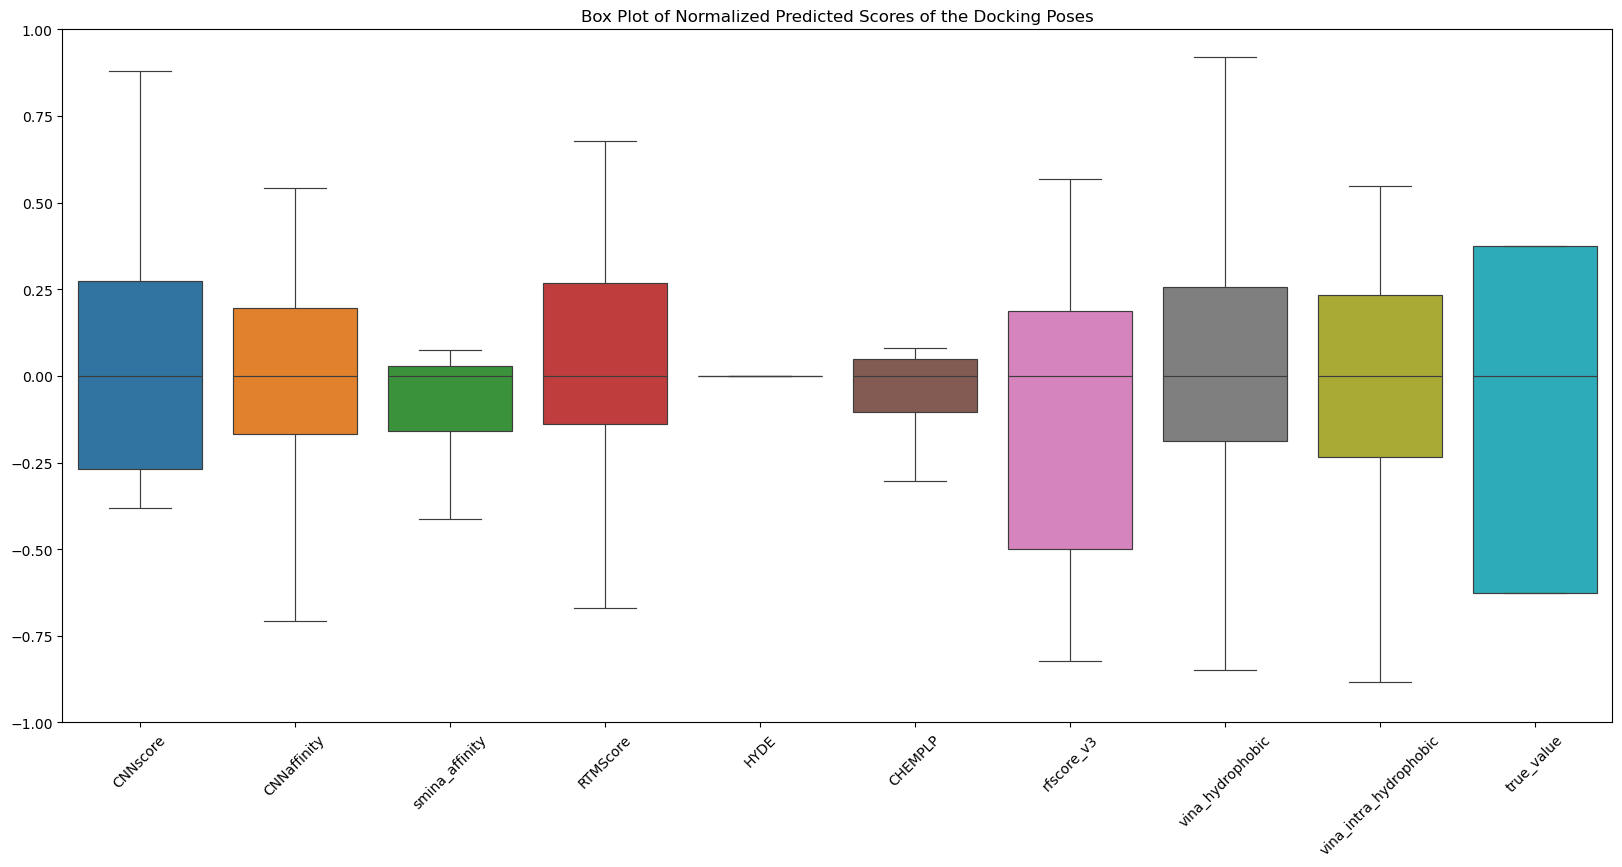

In [11]:
norm_scored_path = OUTPUT / 'all_rescoring_results_merged_norm_robust.csv'
df_rescored = pd.read_csv(str(OUTPUT / 'all_rescoring_results.csv'))

df_rescored_norm = norm_scores(df_rescored_merged)

plt.figure(figsize=(20, 9))
sns.boxplot(data=df_rescored_norm.drop(columns=['activity_class']) ,linewidth=.85, showfliers=False)
plt.ylim(-1, 1)
plt.title('Box Plot of Normalized Predicted Scores of the Docking Poses')
plt.xticks(rotation=45) 
plt.show()

df_rescored_norm.to_csv(str(norm_scored_path), index=False)

## Pose Score Optimization

### Executing optimization function for different regularization

In [12]:
regs = [0, 0.3, 0.5, 0.7, 1, 3, 5, 10, 50]
X, y, docking_cost, scoring_cost, docking_tools, scoring_tools = scores_preprocessing(df_rescored_merged)
best_weights = score_pose_optimization(X, y, docking_cost, scoring_cost, weights_path= DATA / 'best_weights_all_reg_nocoll_abs.pkl.npy', alphas=regs, iter=500)
best_weights

100%|██████████| 150/150 [00:00<00:00, 10609.00it/s]


{0: array([ 0.06052566,  0.09143236, -0.21542251,  1.57871441,  0.01284786,
        -0.25091847,  0.03708087,  0.33071441,  0.0028617 , -0.22055987,
         0.3298587 ,  0.03308206, -0.24248488,  0.20802495, -0.00837271]),
 0.3: array([ 8.18024520e-01,  4.42286192e-01,  2.83908644e-01,  4.57133676e-01,
         1.03337705e-01,  1.28012926e-01,  5.63623207e-02,  1.03747907e+00,
         6.74366301e-01,  5.51888579e-01, -1.40733620e-07, -1.70062642e-07,
         3.31679814e-07,  3.30561500e-08,  2.18646070e-07]),
 0.5: array([ 8.53593257e-01,  5.90680583e-01,  8.36588438e-01,  3.60468793e-01,
         9.09087555e-02,  4.71847544e-02,  6.04591626e-01,  2.81339004e-01,
         6.10037369e-01,  8.83671229e-01,  1.43567670e-07, -8.09443031e-08,
        -2.04506221e-07,  8.00482357e-09, -2.25486530e-08]),
 0.7: array([ 4.14652324e-01,  9.06638869e-02, -1.35679090e-01,  7.44045203e-02,
         5.91396152e-02,  5.45365841e-01,  3.13196818e+00,  4.00383292e-02,
         2.64147549e-02,  2.017

### Check the correlation of each alpha with the true value

In [13]:
for alpha in best_weights.keys():
    c_r, c_d = prepare_parameters(best_weights[alpha])
    preds = pd.DataFrame({'prediction': prediction(c_r, c_d, X), 'ground truth': y})
    corr = preds.corr('spearman')['ground truth']['prediction']
    # sns.lmplot(data=preds, x='prediction', y='ground truth')
    print(f"Using alpha {alpha} give a correlation of : {corr}")

RuntimeError: The size of tensor a (9) must match the size of tensor b (10) at non-singleton dimension 2

### Mapping the normalized weights to docking tools and scoring functions

In [14]:
selected_docking = {}
selected_rescoring = {}
for alpha in best_weights.keys():
    normalized_weights = mapping_normalized_weights(best_weights[alpha], scoring_tools, docking_tools)
    print(f"Using alpha {alpha} give normalized weights: \n{normalized_weights}\n")
    #extract the tools that is above 0.5 in a list
    selected_docking[alpha] = [key for key, value in list(normalized_weights.items())[:5] if value > 0.5]
    selected_rescoring[alpha] = [key for key, value in list(normalized_weights.items())[6:] if value > 0.5]
    print(f"Using alpha {alpha} give selected tools: \n For Docking:{selected_docking[alpha]}\n For Rescoring:{selected_rescoring[alpha]}\n")

Using alpha 0 give normalized weights: 
{'flexx': 0.038307424941427706, 'gnina': 1.0, 'localdiffdock': 0.4814711755597849, 'plants': 0.0, 'smina': 0.7871317979060262, 'CNNscore': 0.17022219862992502, 'CNNaffinity': 0.18711449582681922, 'smina_affinity': 0.019400590273120803, 'RTMScore': 1.0, 'HYDE': 0.14416352490129639, 'CHEMPLP': 0.0, 'rfscore_v3': 0.1574082658069239, 'vina_hydrophobic': 0.31789594758864076, 'vina_intra_hydrophobic': 0.13870551487660682}

Using alpha 0 give selected tools: 
 For Docking:['gnina', 'smina']
 For Rescoring:['RTMScore']

Using alpha 0.3 give normalized weights: 
{'flexx': 1.0, 'gnina': 5.314299797983338e-08, 'localdiffdock': 0.0, 'plants': 9.091369542974891e-07, 'smina': 3.680430026498131e-07, 'CNNscore': 0.7763216743386354, 'CNNaffinity': 0.39335162783000477, 'smina_affinity': 0.23192583682172088, 'RTMScore': 0.40848487663885635, 'HYDE': 0.04787950533351667, 'CHEMPLP': 0.07302964187648502, 'rfscore_v3': 0.0, 'vina_hydrophobic': 1.0, 'vina_intra_hydrophob

## Consensus Ranking

In [15]:
ranking_methods = [
                'best_ECR' ,
                'ECR_average',
                'average_ECR' ,
                'rank_by_rank' ,
                'rank_by_vote' ,
                'rank_by_number',
                'best_Zscore',
                'average_Zscore',
                'weighted_ECR'
                ]

In [16]:
from src.ranking import *
poses_ranking(
    ranking_methods,
    df_rescored_norm,
    OUTPUT,
    weights=normalized_weights,
)

Number of docking programs: 5, ['flexx', 'gnina', 'localdiffdock', 'plants', 'smina']
Number of rescoring methods: 9, ['CNNscore', 'CNNaffinity', 'smina_affinity', 'RTMScore', 'HYDE', 'CHEMPLP', 'rfscore_v3', 'vina_hydrophobic', 'vina_intra_hydrophobic']
Number of possible combinations for every ranking method: 15841
 With total combinations : 142569
All poses are ranked with all consensus methods ..


### Visualize consensus SBVS workflow

In [6]:
corr_df = pd.read_csv(OUTPUT / f'correlations_general/all_ranked.csv')
corr_df.head(10)

,docking_tool,scoring_function,spearman_correlation,cost_per_pipeline,enrichment_factor,ranking_method
0,"['flexx', 'smina']","['CNNscore', 'HYDE', 'RTMScore', 'rfscore_v3']",1.0,137.33,0,method6_Zscore_best
1,"['flexx', 'smina']","['CHEMPLP', 'CNNaffinity', 'CNNscore', 'rfscor...",1.0,120.64,0,method6_Zscore_best
2,"['flexx', 'smina']","['CHEMPLP', 'CNNaffinity', 'CNNscore', 'RTMSco...",1.0,121.64,0,method6_Zscore_best
3,"['flexx', 'smina']","['CHEMPLP', 'CNNaffinity', 'CNNscore', 'RTMSco...",1.0,121.64,0,method6_Zscore_best
4,"['flexx', 'smina']","['CHEMPLP', 'CNNaffinity', 'CNNscore', 'RTMSco...",1.0,121.64,0,method6_Zscore_best
5,"['flexx', 'smina']","['CNNaffinity', 'HYDE', 'rfscore_v3', 'smina_a...",1.0,136.33,0,method6_Zscore_best
6,"['flexx', 'smina']","['CNNaffinity', 'HYDE', 'rfscore_v3', 'vina_hy...",1.0,140.13,0,method6_Zscore_best
7,"['flexx', 'smina']","['CNNaffinity', 'HYDE', 'rfscore_v3', 'vina_in...",1.0,140.13,0,method6_Zscore_best
8,"['flexx', 'smina']","['CNNaffinity', 'HYDE', 'smina_affinity', 'vin...",1.0,136.33,0,method6_Zscore_best
9,"['flexx', 'smina']","['HYDE', 'RTMScore', 'smina_affinity', 'vina_h...",1.0,137.33,0,method6_Zscore_best


In [12]:
corr_df.loc[0,'enrichment_factor']

0

In [17]:
# select best balanced workflow by looking into a range of max 0.05 difference in spearman correlation and select the one with lowest enrichment factor and not less than 0.5 in enrichment_factor

range_workflows = corr_df[(corr_df['spearman_correlation'] >= corr_df['spearman_correlation'].max() - 0.05) &
                          (corr_df['enrichment_factor'] >= corr_df.loc[0, 'enrichment_factor'] - 0.5)]
# select row with the minimum cost value
range_workflows.loc[range_workflows['cost_per_pipeline'].idxmin()]

docking_tool                  ['flexx']
scoring_function        ['CNNaffinity']
spearman_correlation                1.0
cost_per_pipeline                  6.43
enrichment_factor                     0
ranking_method              method8_RbN
Name: 18051, dtype: object

# Deploying optimal balanced SBVS workflow
- By default, workflows within 5% from highest spearman correlation and 0.5 enrichment factor with least runtime cost is selected

In [18]:
selected_workflows = corr_df[(corr_df['spearman_correlation'] >= corr_df['spearman_correlation'].max() - 0.05) &
                          (corr_df['enrichment_factor'] >= corr_df.loc[0, 'enrichment_factor'] - 0.5)]
# select row with the minimum cost value
selected_workflow = range_workflows.loc[range_workflows['cost_per_pipeline'].idxmin()]

selected_docking_tools = selected_workflow['docking_tool']
selected_scoring_functions = selected_workflow['scoring_function']
ranking_method = selected_workflow['ranking_method']

print(f"Docking tools: {(selected_docking_tools)}\nScoring tools: {selected_scoring_functions}\nRanking method: {ranking_method}")

Docking tools: ['flexx']
Scoring tools: ['CNNaffinity']
Ranking method: method8_RbN


## Directory for larger Dataset

In [5]:
OUTPUT_larger_data = OUTPUT / "chembl_results"
OUTPUT_larger_data.mkdir(exist_ok=True)

## Ligands preparation

In [8]:
chembl_library = str(DATA / 'test_library_10cpds.sdf')
prepared_chembl_data_path = OUTPUT_larger_data / f"chembl_data_prepared.sdf"
run_gypsumdl(str(chembl_library), prepared_chembl_data_path)

Molecules are already prepared by Gypsum-DL


## Molecular Docking of selected tools

In [9]:
docking(
        docking_methods=selected_docking_tools,
        protein_file=protein_file,
        current_library=prepared_chembl_data_path,
        ref_file=ref_file,
        exhaustiveness=32,
        n_poses=10,
        OUTPUT=OUTPUT_larger_data
        )



Docking with FLEXX is running ...

Reference ligand is already in SDF format
Compounds are already docked with FlexX v 6.0
ID format is correct


Docking with SMINA is running ...

Compounds are already docked with SMINA


Concatenating all poses in one SDF file ...

Compounds are already docked and concatenated, CHECK /home/hamza/github/MolDockLab/ECFT-VS-pipeline/test_data/results/chembl_results/allposes.sdf


## Interaction hotspots detection using PLIPify

In [6]:
actives_path = actives_extraction( 
    DATA / 'results/allposes.sdf', 
    DATA / 'results/all_rescoring_results_merged.csv', 
    docking_tool=selected_docking_tools
    )

actives_paths = split_sdf_path(actives_path)

Number of active compounds: 20


SDF splitting: 100%|██████████| 20/20 [00:00<00:00, 3459.22it/s]


100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

muscle 5.1.linux64 []  32.0Gb RAM, 24 cores
Built May 16 2023 07:53:40
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 20 seqs, length avg 280 max 280

00:00 7.6Mb   100.0% Derep 1 uniques, 18 dupes
00:00 7.8Mb   100.0% UCLUST 1 seqs EE<0.01, 0 centroids, 0 members
00:00 8.0Mb   100.0% UCLUST 1 seqs EE<0.30, 0 centroids, 0 members
00:00 8.0Mb   100.0% Make cluster MFAs                            
1 clusters pass 1                     
1 clusters pass 2
00:00 8.0Mb  Align cluster 1 / 1 (1 seq)
00:00 8.0Mb   100.0% Consensus sequences
00:00 8.0Mb  CPU has 24 cores, defaulting to 20 threads
Inserting 19 dupes... done.


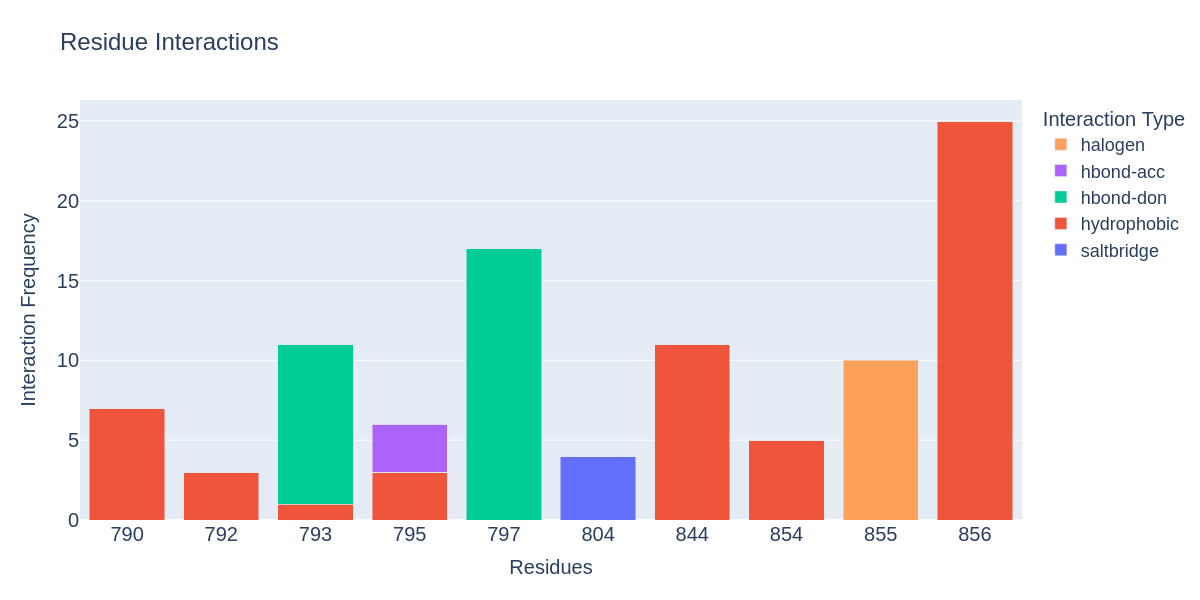

In [7]:
output_file= OUTPUT / 'egfr_interactions_X.png'
fp_focused = plipify_fp_interaction(
    ligands_path=actives_paths, 
    protein_path=protein_file, 
    protein_name='EGFR', 
    chains='X',
    output_file=output_file
    )
fp_focused['total_interactions'] = fp_focused.sum(axis=1)
display(Image(filename=output_file))

## Interaction fingerprints generations

In [11]:
included_chains = ['X']
protein_name = 'egfr'
interactions_dict_path = OUTPUT_larger_data / 'fp_allposes.json'
ligands_paths = split_sdf_path(OUTPUT_larger_data / 'allposes.sdf')
allposes_interaction_fp = indiviudal_interaction_fp_generator(ligands_paths, 
                                                              protein_file, 
                                                              protein_name, 
                                                              included_chains, 
                                                              interactions_dict_path)

SDF splitting: 100%|██████████| 184/184 [00:00<00:00, 3328.97it/s]

muscle 5.1.linux64 []  32.0Gb RAM, 24 cores
Built May 16 2023 07:53:40
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 1 seqs, length avg 280 max 280

00:00 7.6Mb   100.0% Derep 0 uniques, 0 dupes
00:00 7.8Mb   100.0% UCLUST 1 seqs EE<0.01, 0 centroids, 0 members
00:00 8.0Mb   100.0% UCLUST 1 seqs EE<0.30, 0 centroids, 0 members
00:00 8.0Mb   100.0% Make cluster MFAs                            
1 clusters pass 1                     
1 clusters pass 2
00:00 8.0Mb  Align cluster 1 / 1 (1 seq)
00:00 8.0Mb   100.0% Consensus sequences
00:00 8.0Mb  CPU has 24 cores, defaulting to 20 threads


TypeError: 'PosixPath' object is not subscriptable

In [18]:
interactions_df = read_interactions_json(
    json_file=interactions_dict_path, 
    output_file=OUTPUT_larger_data / 'allposes_interaction_fps_final.csv'
    )
        
interactions_df  

Interactions are converted to CSV file.


,Poses,790X,791X,792X,793X,794X,795X,796X,797X,799X,800X,803X,804X,837X,841X,842X,844X,854X,855X,856X
0,CHEMBL1830130_flexx_01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,CHEMBL1830130_flexx_02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,CHEMBL1830130_flexx_03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,CHEMBL1830130_flexx_04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,CHEMBL1830130_flexx_05,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,CHEMBL5088102_smina_5,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
180,CHEMBL5088102_smina_6,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1
181,CHEMBL5088102_smina_7,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
182,CHEMBL5088102_smina_8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


## Frequent interactions with actives are used as key interactions
- By default top four interactions in actives are used for interactions filtration

In [19]:
key_interactions_resno = list(fp_focused.sort_values(by='total_interactions', ascending=False).head(4).index)
chain = 'X'
key_interactions_resno = [f'{resno}{chain}' for resno in key_interactions_resno]
print(f"Key interactions are with residues: {key_interactions_resno}")

Key interactions are with residues: ['856X', '797X', '844X', '793X']


In [20]:
agg_interx_df = interactions_aggregation(
                     interactions_df=interactions_df.reset_index(),
                     important_interactions=key_interactions_resno,
                     id_column='Poses'
                    )
agg_interx_df.replace(0, np.nan, inplace=True)

# Drop rows with any NaN values
agg_interx_df.dropna(inplace=True)
agg_interx_df

,id,856X,797X,844X,793X
0,CHEMBL1830130,18,4.0,16,5
1,CHEMBL2424807,17,2.0,11,18
2,CHEMBL255871,18,2.0,17,16
3,CHEMBL3425665,20,4.0,11,17
4,CHEMBL4068047,8,1.0,10,5
5,CHEMBL4074615,9,8.0,9,2
6,CHEMBL4164936,8,8.0,16,9
8,CHEMBL504173,12,8.0,9,7
9,CHEMBL5088102,7,7.0,10,13


## Selected Scoring functions for correlation pipeline

In [21]:
docked_library_path = OUTPUT_larger_data / "allposes.sdf"

rescoring_function(
    selected_scoring_functions,
    protein_file,
    docked_library_path,
    ref_file,
    ncpu=7,
)



Now rescoring with CNNSCORE ... ⌛⌛ 
cnnscore is already excuted
cnnscore is already read


Now rescoring with HYDE ... ⌛⌛ 
hyde is already excuted
hyde is already read


Now rescoring with RTMSCORE ... ⌛⌛ 
rtmscore is already excuted
rtmscore is already read


Now rescoring with RFSCORE_V3 ... ⌛⌛ 
rfscore_v3 is already excuted
rfscore_v3 is already read


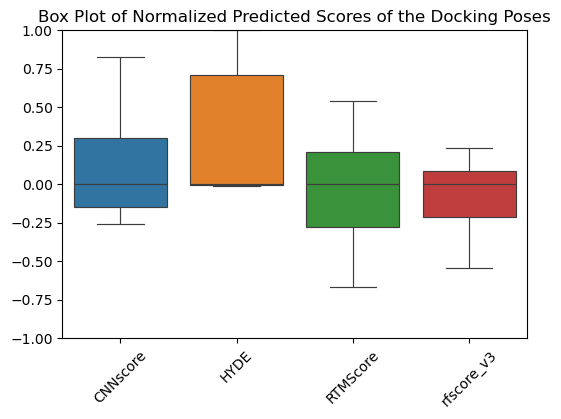

In [22]:
norm_scored_path = OUTPUT_larger_data / 'all_rescoring_results_norm_robust.csv'
df_rescored = pd.read_csv(str(OUTPUT_larger_data / 'all_rescoring_results.csv'))

df_rescored_norm = norm_scores(df_rescored)

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_rescored_norm ,linewidth=.85, showfliers=False)
plt.ylim(-1, 1)
plt.title('Box Plot of Normalized Predicted Scores of the Docking Poses')
plt.xticks(rotation=45) 
plt.show()

df_rescored_norm.to_csv(str(norm_scored_path), index=False)

In [23]:
rescored_library = pd.read_csv(str(norm_scored_path))
rescored_library['id'] = rescored_library.ID.str.split('_').str[0]

## Selected Ranking Method

In [30]:
print(f'Selected Ranking method: {ranking_method}')

Selected Ranking method: method6_Zscore_best


In [33]:
from src.consensus_rank import *

ranked_scores = method6_Zscore_best(
    rescored_library,
    weight=0.5, 
    selected_scores=selected_scoring_functions,
    id_column='id'
    )

ranked_scores = ranked_scores.sort_values(by=ranked_scores.columns[-1], ascending=False)
ranked_scores

,id,method6_Zscore_best
74,CHEMBL3425665,1.681756
135,CHEMBL4457733,1.137059
88,CHEMBL4068047,1.023448
50,CHEMBL255871,0.996854
118,CHEMBL4164936,0.833680
34,CHEMBL2424807,0.624783
94,CHEMBL4074615,0.503110
167,CHEMBL5088102,0.495069
8,CHEMBL1830130,0.210332
156,CHEMBL504173,0.013385
